<a href="https://colab.research.google.com/github/Ksenyff/ICV-2024/blob/main/Spiridonova_Homography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

## Описание

Дано изображение документа, сделанное под углом (с перспективныи искажением).

Ваша задача состоит в следующем:
1. Вручную отметить 4 угла документа (координаты в пикселях).
2. Вычислить матрицу гомографии для преобразования выбранных точек в прямоугольник (например, если было сделано фото листа А4, то прямоугольник размером 297 на 210 мм).
3. Примените перспективное преобразование над изображением для получения "выпрямленного" изображения документа.

**Входные данные**: исходное изображение документа (или любого другого плоского объекта с выраженными углами - минимум 4 угла).

**Выходные данные**: исправленное изображение документа (будто документ расположен параллельно плоскости матрицы камеры).

## Этапы выполнения

### 1. Выбор угловых точек

- Загрузить изображение и позволить пользователю кликнуть на 4 угла документа (порядок: левый-верхний, правый-верхний, правый-нижний, левый-нижний). На первых этапах тестирования можете задать координаты углов в программе.
- Сохраните координаты как `src_corner_points`.

### 2. Определение целевых размеров

- Исправленный документ должен иметь более или менее корректные пропорции (например, соотношение сторон листа А4 = 297 / 210 = 1.414).

- Задайте координаты исправленных углов как `dst_corner_points`:
```python
dst_corner_points = np.array([
  [0, 0],          # левый-верхний угол (LT)
  [width, 0],      # правый-верхний угол (RT)
  [width, height], # правый-нижний угол (RB)
  [0, height]      # левый-нижний угол (LB)
])
```

### 3. Расчет матрицы гомографии

- Использовать `cv2.getPerspectiveTransform()` для вычисления матрицы `H`, преобразующей `src_corner_points` в `dst_corner_points`.

### 4. Применение преобразования

- Использовать `cv2.warpPerspective()` с матрицей `H` для получения исправленного изображения.

### 5. Визуализация и сохранение

- Показать исходное и исправленное изображения "бок о бок" (склеить изображения так чтобы между ними был белый разделитель толщиной 32 пикселя).
- Сохранить результат в формате `PNG` под любым названием (например, `doc-homography.PNG`). Файл должен корректно открываться.

### 6. Работа с видеопотоком камеры

- Используйте видеопоток с камеры для захвата изображения. Изображение должно захватываться по запросу пользователя - например, через ROS-сервис или стандартный поток ввода (терминал).

Условно: "ожидаем пока пользователь нажмет кнопку S и тогда берем текущий кадр с камеры".

### Опционально

1. Автоматическое опеределение углов через Canny, контуры и аппроксимацию многоугольника.

2. Вычисление исходного соотношения сторон документа по многоугольнику.

3. Использовать видеопоток с камеры для коррекции перспективного искажения "на лету". Вычисление углов и исправление осуществляется для всех кадров видеопотока по мере их "поступления".


## Пример структуры кода (без ROS)

```python
import cv2
import numpy as np

# Загрузка изображения
image = cv2.imread("document.jpg") # или получение кадра из ROS-топика

# Этап 1: Ручной выбор углов (можно через cv2.setMouseCallback())
src_corner_points = [...]  # 4 точки, введенные пользователем

# Этап 2: Целевые координаты (например, в соотношении сторон формата A4)
width, height = 210, 297
dst_corner_points = np.array([...], dtype=np.float32)

# Этап 3: Вычисление матрицы гомографии
H = cv2.getPerspectiveTransform(src_corner_points, dst_corner_points)

# Этап 4: Перспективное преобразование
corrected_img = cv2.warpPerspective(image, H, (width, height))

# Этап 5: Визуализация
cv2.imshow("Исходное", image)
cv2.imshow("Исправленное", corrected_img)
cv2.waitKey(0)
```

## Пример ручного выбора углов (мышкой)

```python
class CornerSelector:
    def __init__(self, image, window_name="Select 4 сorners"):
        self.image = image.copy()
        self.display_image = image.copy()
        self.window_name = window_name
        self.corners = []
        self.is_completed = False
        
    def select_corners(self):
        cv2.namedWindow(self.window_name)
        cv2.setMouseCallback(self.window_name, self._mouse_callback)
        
        print("Инструкция:")
        print("1. Кликните ЛКМ по 4 углам документа (по часовой стрелке или против)")
        print("2. После выбора 4 точек нажмите ESC для завершения")
        
        while True:
            cv2.imshow(self.window_name, self.display_image)
            key = cv2.waitKey(1) & 0xFF
            
            # ESC для завершения или автоматически после 4 точек
            if key == 27 or self.is_completed:
                break
        
        cv2.destroyWindow(self.window_name)
        if not self.is_completed:
          return None
        
        return np.array(self.corners, dtype=np.float32)
    
    def _mouse_callback(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN and len(self.corners) < 4:
            self.corners.append((x, y))
            print(f"Выбрана точка {len(self.corners)}: ({x}, {y})")
            
            # Обновляем изображение с отметками
            self.display_image = self.image.copy()
            for i, (cx, cy) in enumerate(self.corners, 1):
                cv2.circle(self.display_image, (cx, cy), 10, (0, 0, 255), -1)
                cv2.putText(self.display_image, str(i), (cx + 15, cy - 15),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            if len(self.corners) == 4:
                self.is_completed = True
                print("Все 4 точки выбраны!")


# Пример использования
if __name__ == "__main__":
    # Загрузка изображения
    image = ...
    
    # Создаем селектор и запускаем процесс выбора углов
    selector = CornerSelector(image)
    selected_corners = selector.select_corners()
    
    if selected_corners is not None:
        print("\nВыбранные точки:")
        print(selected_corners)
        
        # Здесь можно продолжить с вычислением гомографии...
    else:
        print("Не удалось выбрать 4 точки!")
```

## Вопросы для обсуждения

1. Почему достаточно 4 точке для вычисления гомографии? Почему недостаточно 3 точек?
2. Как повлияет на результат неточное выделение углов документа?

 **Ответы на вопрос:**

1.a)  т.к матрица гомографии представляет собой матрицу 3х3. С учетом масштабируеммости можно сказать ,что матрица имеет 8 степеней свободы. Одна пара точек даёт 2 уравнения. Значит, для решения уравнения необходимо 4 точки, чтобы система стала полной и можно было однозначно восстановить матрицу гомографии.

1.b) При использовании 3х точек , мы получем решение для 6ти уравнений, т.е недоопределенную  систему. Использвание 3х точек хорошо подойдёт для задач: gоворотов,масштабирований,сдвигов, но не для перспективных искажений.

2.Последствия:
Искажение формы документа,cмещение содержимого,yарушение пропорций,потеря информации,возникновение артефакты



Выберите источник изображения:
1 - из интернета, 2 - загрузить файл с устройства: 1
Введите URL изображения (например, .jpg, .png или .webp): https://avatars.dzeninfra.ru/get-zen_doc/1653873/pub_632191eb8cc36e66cd43c1ab_632191f08cc36e66cd43c895/scale_1200

Введите координаты четырех углов документа (по часовой стрелке):
Пример формата: x y
Левый верхний (x y): 0 0
Правый верхний (x y): 797 0
Правый нижний (x y): 797 1197
Левый нижний (x y): 0 1197

Введите размеры выходного изображения (например, А4: ширина=210, высота=297)
Ширина (px): 797
Высота (px): 1197

Результат:


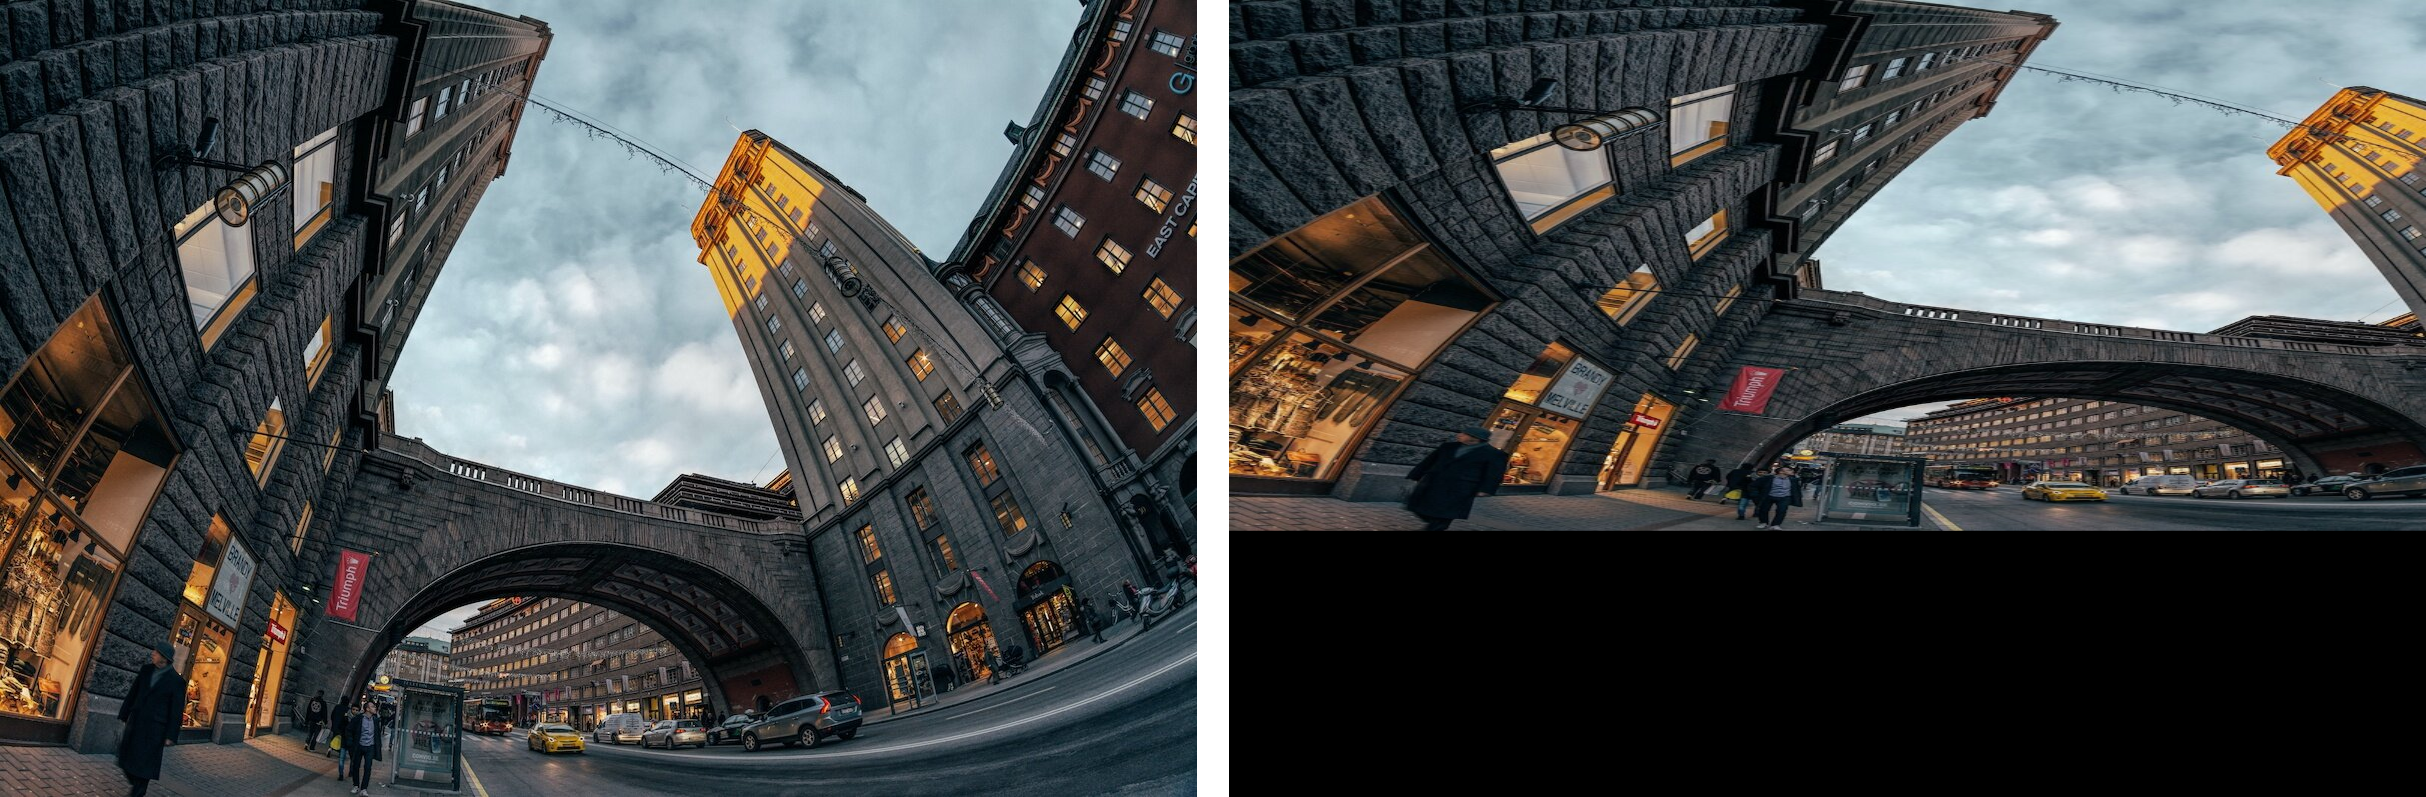


Изображение сохранено как 'corrected_document.png'


In [4]:
import cv2
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from google.colab.patches import cv2_imshow


def load_image_from_url(url):
    """Загружает изображение по URL, включая .webp, и конвертирует в BGR-формат OpenCV"""
    try:
        response = requests.get(url, stream=True, timeout=10)
        if response.status_code != 200:
            print("Ошибка: Невозможно загрузить изображение по URL.")
            return None

        image = Image.open(BytesIO(response.content)).convert("RGB")
        img_array = np.array(image)
        img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)  # RGB -> BGR для OpenCV
        return img_bgr
    except Exception as e:
        print(f"Ошибка при загрузке изображения: {e}")
        return None


def main():
    print("Выберите источник изображения:")
    source = input("1 - из интернета, 2 - загрузить файл с устройства: ")

    image = None

    if source == "1":
        url = input("Введите URL изображения (например, .jpg, .png или .webp): ").strip()
        if not url:
            url = "https://wallpapers.com/images/high/funny-shrek-kcn8nv60431sny2u.webp "
            print(f"Используется пример: {url}")

        image = load_image_from_url(url)
        if image is None:
            print("Не удалось загрузить изображение по указанному URL.")
            return

    elif source == "2":
        print("Загрузите изображение ниже:")
        from google.colab import files
        uploaded = files.upload()
        if not uploaded:
            print("Файл не загружен.")
            return
        filename = next(iter(uploaded))
        image = cv2.imread(filename)
        if image is None:
            print("Ошибка: Не удалось прочитать изображение.")
            return
    else:
        print("Неверный выбор.")
        return

    print("\nВведите координаты четырех углов документа (по часовой стрелке):")
    print("Пример формата: x y")
    src_points = []
    labels = ["Левый верхний", "Правый верхний", "Правый нижний", "Левый нижний"]
    for label in labels:
        while True:
            try:
                coords = input(f"{label} (x y): ")
                x, y = map(int, coords.strip().split())
                src_points.append([x, y])
                break
            except:
                print("Ошибка: Введите два целых числа через пробел.")

    src_points = np.array(src_points, dtype=np.float32)

    print("\nВведите размеры выходного изображения (например, А4: ширина=210, высота=297)")
    width = int(input("Ширина (px): "))
    height = int(input("Высота (px): "))

    dst_points = np.array([
        [0, 0],
        [width, 0],
        [width, height],
        [0, height]
    ], dtype=np.float32)

    H_matrix, mask = cv2.findHomography(src_points, dst_points)
    corrected_img = cv2.warpPerspective(image, H_matrix, (width, height))

    # Отображаем оригинальное и скорректированное изображение рядом
    separator = np.ones((image.shape[0], 32, 3), dtype=np.uint8) * 255
    resized_corrected = cv2.resize(corrected_img, (image.shape[1], image.shape[0]))
    combined = np.hstack((image, separator, resized_corrected))

    print("\nРезультат:")
    cv2_imshow(combined)

    # Сохраняем скорректированное изображение
    output_file = "corrected_document.png"
    cv2.imwrite(output_file, corrected_img)
    print(f"\nИзображение сохранено как '{output_file}'")


if __name__ == "__main__":
    main()